In [109]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
# from keras.datasets import mnist
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras import backend as K
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from time import time
from scipy.spatial.distance import euclidean

### Prepare Reality Mining Data

In [2]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/proc/reality-mining/txt/interim/appsByWeek.txt', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [3]:
# Clean app names
for r in range(len(df.index)):
    if df.iloc[r, 2].find(':') > -1:
        print df.iloc[r]
        df.iloc[r, 2] = 'Phone'

id                                                   11
date                                            2004.44
app     Phone20041027T235032area,cell,nw:5119,40791,TMO
freq                                                  1
Name: 2684, dtype: object
id                                           67
date                                    2004.41
app     Phone??20041009T021013UserActivity:idle
freq                                          1
Name: 15101, dtype: object


In [4]:
df['app'].unique().shape

(200,)

In [5]:
def convert_to_dict(df, col='app'):
    data_dict = {}
    
    unique = list(df[col].unique())
    
    pid = int(df.iloc[0,0])
    date = df.iloc[0, 1]
    data_dict[pid] = {}
    data_dict[pid][date] = np.zeros((len(unique),))
    
    for r in range(1, len(df.index)):
        if int(df.iloc[r, 0]) != pid:
            pid = int(df.iloc[r, 0])
            data_dict[pid] = {}
            date = None
        
        if df.iloc[r, 1] == date:
            try:
                data_dict[pid][date][unique.index(df.iloc[r, 2])] = df.iloc[r, 3]
            except ValueError:
                pass
        else:
            date = df.iloc[r, 1]
            data_dict[pid][date] = np.zeros((len(unique),))
            try:
                data_dict[pid][date][unique.index(df.iloc[r, 2])] = int(df.iloc[r, 3])
            except ValueError:
                pass
    return data_dict, unique

In [6]:
data_dict, unique = convert_to_dict(df)

In [7]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [8]:
x_train, y_train = dict_to_np_array(data_dict)
print x_train.shape, y_train.shape

(1911, 200) (1911,)


In [9]:
x_train = x_train / (x_train.max(axis=1)[:, None] + 1e-5)

In [10]:
y_train

array([ 0,  0,  0, ..., 87, 87, 87])

### Train VAE

In [11]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
original_dim = len(unique)

# network parameters
input_shape = (original_dim, )
intermediate_dim = 10
batch_size = 128
latent_dim = 2
# epochs = 50

In [13]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 200)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           2010        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            22          dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            22          dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [14]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 200)               2200      
Total params: 2,230
Trainable params: 2,230
Non-trainable params: 0
_________________________________________________________________


In [15]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [16]:
reconstruction_loss = categorical_crossentropy(inputs,
                                          outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=0.001, decay=1.0e-6))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 2054      
_________________________________________________________________
decoder (Model)              (None, 200)               2230      
Total params: 4,284
Trainable params: 4,284
Non-trainable params: 0
_________________________________________________________________


In [17]:
vae.fit(x_train,
        epochs=1000,
        batch_size=batch_size)

Epoch 1/1000
1911/1911 [==============================] - 0s 235us/step - loss: 2382.1119
Epoch 2/1000
1911/1911 [==============================] - 0s 33us/step - loss: 2364.1811
Epoch 3/1000
1911/1911 [==============================] - 0s 33us/step - loss: 2343.7150
Epoch 4/1000
1911/1911 [==============================] - 0s 34us/step - loss: 2319.9106
Epoch 5/1000
1911/1911 [==============================] - 0s 35us/step - loss: 2290.8410
Epoch 6/1000
1911/1911 [==============================] - 0s 32us/step - loss: 2253.3752
Epoch 7/1000
1911/1911 [==============================] - 0s 37us/step - loss: 2195.3462
Epoch 8/1000
1911/1911 [==============================] - 0s 27us/step - loss: 2115.3514
Epoch 9/1000
1911/1911 [==============================] - 0s 26us/step - loss: 2001.7763
Epoch 10/1000
1911/1911 [==============================] - 0s 26us/step - loss: 1839.0431
Epoch 11/1000
1911/1911 [==============================] - 0s 43us/step - loss: 1617.7043
Epoch 12/1000
1911

1911/1911 [==============================] - 0s 39us/step - loss: 879.3396
Epoch 93/1000
1911/1911 [==============================] - 0s 76us/step - loss: 879.0240
Epoch 94/1000
1911/1911 [==============================] - 0s 54us/step - loss: 878.8224
Epoch 95/1000
1911/1911 [==============================] - 0s 50us/step - loss: 878.6589
Epoch 96/1000
1911/1911 [==============================] - 0s 43us/step - loss: 878.4589
Epoch 97/1000
1911/1911 [==============================] - 0s 42us/step - loss: 878.2218
Epoch 98/1000
1911/1911 [==============================] - 0s 43us/step - loss: 878.0943
Epoch 99/1000
1911/1911 [==============================] - 0s 39us/step - loss: 877.8455
Epoch 100/1000
1911/1911 [==============================] - 0s 41us/step - loss: 877.5858
Epoch 101/1000
1911/1911 [==============================] - 0s 42us/step - loss: 877.1693
Epoch 102/1000
1911/1911 [==============================] - 0s 40us/step - loss: 877.1218
Epoch 103/1000
1911/1911 [======

1911/1911 [==============================] - 0s 35us/step - loss: 866.5438
Epoch 184/1000
1911/1911 [==============================] - 0s 34us/step - loss: 866.4228
Epoch 185/1000
1911/1911 [==============================] - 0s 26us/step - loss: 866.3342
Epoch 186/1000
1911/1911 [==============================] - 0s 25us/step - loss: 866.3706
Epoch 187/1000
1911/1911 [==============================] - 0s 27us/step - loss: 866.2713
Epoch 188/1000
1911/1911 [==============================] - 0s 36us/step - loss: 866.2617
Epoch 189/1000
1911/1911 [==============================] - 0s 60us/step - loss: 866.2301
Epoch 190/1000
1911/1911 [==============================] - 0s 56us/step - loss: 866.1364
Epoch 191/1000
1911/1911 [==============================] - 0s 28us/step - loss: 866.0337
Epoch 192/1000
1911/1911 [==============================] - 0s 24us/step - loss: 866.0527
Epoch 193/1000
1911/1911 [==============================] - 0s 24us/step - loss: 865.8450
Epoch 194/1000
1911/1911 

1911/1911 [==============================] - 0s 51us/step - loss: 861.0471
Epoch 274/1000
1911/1911 [==============================] - 0s 53us/step - loss: 860.9717
Epoch 275/1000
1911/1911 [==============================] - 0s 44us/step - loss: 860.7617
Epoch 276/1000
1911/1911 [==============================] - 0s 49us/step - loss: 860.6812
Epoch 277/1000
1911/1911 [==============================] - 0s 47us/step - loss: 860.5399
Epoch 278/1000
1911/1911 [==============================] - 0s 47us/step - loss: 860.6749
Epoch 279/1000
1911/1911 [==============================] - 0s 35us/step - loss: 860.6431
Epoch 280/1000
1911/1911 [==============================] - 0s 27us/step - loss: 860.4696
Epoch 281/1000
1911/1911 [==============================] - 0s 25us/step - loss: 860.4981
Epoch 282/1000
1911/1911 [==============================] - 0s 25us/step - loss: 860.3676
Epoch 283/1000
1911/1911 [==============================] - 0s 27us/step - loss: 860.4052
Epoch 284/1000
1911/1911 

1911/1911 [==============================] - 0s 32us/step - loss: 854.3630
Epoch 364/1000
1911/1911 [==============================] - ETA: 0s - loss: 854.084 - 0s 70us/step - loss: 854.3280
Epoch 365/1000
1911/1911 [==============================] - 0s 60us/step - loss: 854.1176
Epoch 366/1000
1911/1911 [==============================] - 0s 47us/step - loss: 854.3066
Epoch 367/1000
1911/1911 [==============================] - 0s 46us/step - loss: 854.1246
Epoch 368/1000
1911/1911 [==============================] - 0s 47us/step - loss: 854.0449
Epoch 369/1000
1911/1911 [==============================] - 0s 44us/step - loss: 854.1084
Epoch 370/1000
1911/1911 [==============================] - 0s 39us/step - loss: 853.8927
Epoch 371/1000
1911/1911 [==============================] - 0s 39us/step - loss: 853.9776
Epoch 372/1000
1911/1911 [==============================] - 0s 72us/step - loss: 853.7238
Epoch 373/1000
1911/1911 [==============================] - 0s 59us/step - loss: 853.6809

1911/1911 [==============================] - 0s 38us/step - loss: 850.0666
Epoch 454/1000
1911/1911 [==============================] - 0s 30us/step - loss: 850.0689
Epoch 455/1000
1911/1911 [==============================] - 0s 26us/step - loss: 850.0676
Epoch 456/1000
1911/1911 [==============================] - 0s 27us/step - loss: 850.0184
Epoch 457/1000
1911/1911 [==============================] - 0s 29us/step - loss: 849.9194
Epoch 458/1000
1911/1911 [==============================] - 0s 28us/step - loss: 849.8378
Epoch 459/1000
1911/1911 [==============================] - 0s 27us/step - loss: 849.7114
Epoch 460/1000
1911/1911 [==============================] - 0s 28us/step - loss: 849.8462
Epoch 461/1000
1911/1911 [==============================] - 0s 27us/step - loss: 849.6564
Epoch 462/1000
1911/1911 [==============================] - 0s 25us/step - loss: 849.8542
Epoch 463/1000
1911/1911 [==============================] - 0s 24us/step - loss: 849.7591
Epoch 464/1000
1911/1911 

1911/1911 [==============================] - 0s 42us/step - loss: 846.5617
Epoch 544/1000
1911/1911 [==============================] - 0s 35us/step - loss: 846.5112
Epoch 545/1000
1911/1911 [==============================] - 0s 35us/step - loss: 846.4737
Epoch 546/1000
1911/1911 [==============================] - 0s 32us/step - loss: 846.3941
Epoch 547/1000
1911/1911 [==============================] - 0s 32us/step - loss: 846.3021
Epoch 548/1000
1911/1911 [==============================] - 0s 28us/step - loss: 846.2864
Epoch 549/1000
1911/1911 [==============================] - 0s 25us/step - loss: 846.3406
Epoch 550/1000
1911/1911 [==============================] - 0s 27us/step - loss: 846.3289
Epoch 551/1000
1911/1911 [==============================] - 0s 53us/step - loss: 846.0780
Epoch 552/1000
1911/1911 [==============================] - 0s 70us/step - loss: 846.1423
Epoch 553/1000
1911/1911 [==============================] - 0s 47us/step - loss: 845.9188
Epoch 554/1000
1911/1911 

1911/1911 [==============================] - 0s 68us/step - loss: 843.4686
Epoch 635/1000
1911/1911 [==============================] - 0s 28us/step - loss: 843.6597
Epoch 636/1000
1911/1911 [==============================] - 0s 25us/step - loss: 843.6142
Epoch 637/1000
1911/1911 [==============================] - 0s 67us/step - loss: 843.5230
Epoch 638/1000
1911/1911 [==============================] - 0s 53us/step - loss: 843.3877
Epoch 639/1000
1911/1911 [==============================] - 0s 48us/step - loss: 843.4698
Epoch 640/1000
1911/1911 [==============================] - 0s 42us/step - loss: 843.4215
Epoch 641/1000
1911/1911 [==============================] - 0s 47us/step - loss: 843.5464
Epoch 642/1000
1911/1911 [==============================] - 0s 40us/step - loss: 843.3597
Epoch 643/1000
1911/1911 [==============================] - 0s 26us/step - loss: 843.3429
Epoch 644/1000
1911/1911 [==============================] - 0s 50us/step - loss: 843.3503
Epoch 645/1000
1911/1911 

Epoch 725/1000
1911/1911 [==============================] - 0s 73us/step - loss: 841.8970
Epoch 726/1000
1911/1911 [==============================] - 0s 31us/step - loss: 841.7084
Epoch 727/1000
1911/1911 [==============================] - 0s 52us/step - loss: 841.7270
Epoch 728/1000
1911/1911 [==============================] - 0s 54us/step - loss: 841.8243
Epoch 729/1000
1911/1911 [==============================] - 0s 47us/step - loss: 841.6834
Epoch 730/1000
1911/1911 [==============================] - 0s 43us/step - loss: 841.7539
Epoch 731/1000
1911/1911 [==============================] - 0s 37us/step - loss: 841.8601
Epoch 732/1000
1911/1911 [==============================] - 0s 26us/step - loss: 841.6550
Epoch 733/1000
1911/1911 [==============================] - 0s 54us/step - loss: 841.7750
Epoch 734/1000
1911/1911 [==============================] - 0s 78us/step - loss: 841.8186
Epoch 735/1000
1911/1911 [==============================] - 0s 72us/step - loss: 841.7309
Epoch 736/

1911/1911 [==============================] - 0s 35us/step - loss: 840.6934
Epoch 816/1000
1911/1911 [==============================] - 0s 31us/step - loss: 840.7418
Epoch 817/1000
1911/1911 [==============================] - 0s 26us/step - loss: 840.5827
Epoch 818/1000
1911/1911 [==============================] - 0s 47us/step - loss: 840.5758
Epoch 819/1000
1911/1911 [==============================] - 0s 80us/step - loss: 840.5171
Epoch 820/1000
1911/1911 [==============================] - 0s 64us/step - loss: 840.5856
Epoch 821/1000
1911/1911 [==============================] - 0s 44us/step - loss: 840.7986
Epoch 822/1000
1911/1911 [==============================] - 0s 43us/step - loss: 840.5749
Epoch 823/1000
1911/1911 [==============================] - 0s 42us/step - loss: 840.5561
Epoch 824/1000
1911/1911 [==============================] - 0s 29us/step - loss: 840.7052
Epoch 825/1000
1911/1911 [==============================] - 0s 57us/step - loss: 840.5172
Epoch 826/1000
1911/1911 

1911/1911 [==============================] - 0s 55us/step - loss: 839.7593
Epoch 907/1000
1911/1911 [==============================] - 0s 74us/step - loss: 839.7301
Epoch 908/1000
1911/1911 [==============================] - 0s 56us/step - loss: 839.7287
Epoch 909/1000
1911/1911 [==============================] - 0s 25us/step - loss: 839.6792
Epoch 910/1000
1911/1911 [==============================] - 0s 26us/step - loss: 839.7448
Epoch 911/1000
1911/1911 [==============================] - 0s 25us/step - loss: 839.5807
Epoch 912/1000
1911/1911 [==============================] - 0s 25us/step - loss: 839.7163
Epoch 913/1000
1911/1911 [==============================] - 0s 27us/step - loss: 839.6592
Epoch 914/1000
1911/1911 [==============================] - 0s 27us/step - loss: 839.4767
Epoch 915/1000
1911/1911 [==============================] - 0s 78us/step - loss: 839.6103
Epoch 916/1000
1911/1911 [==============================] - 0s 74us/step - loss: 839.6926
Epoch 917/1000
1911/1911 

1911/1911 [==============================] - 0s 34us/step - loss: 838.9585
Epoch 997/1000
1911/1911 [==============================] - 0s 33us/step - loss: 839.0942
Epoch 998/1000
1911/1911 [==============================] - 0s 59us/step - loss: 838.9766
Epoch 999/1000
1911/1911 [==============================] - 0s 56us/step - loss: 839.0214
Epoch 1000/1000
1911/1911 [==============================] - 0s 55us/step - loss: 838.9910


In [18]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs[2])

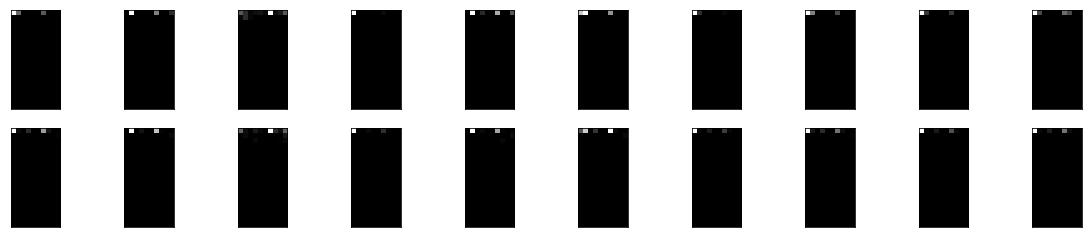

In [19]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

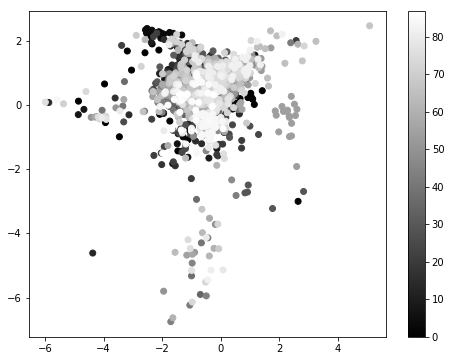

In [20]:
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)
x_test_encoded = np.array(x_test_encoded)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_train)
plt.colorbar()
plt.show()

In [21]:
pair_dist = []
pair_label = []

for i in np.arange(x_test_encoded[2].shape[0]):
    for j in range(i, x_test_encoded[2].shape[0]):
        d = np.sqrt(np.power(x_test_encoded[2, i] - x_test_encoded[2, j], 2).sum())
        pair_dist.append(d)
        
        if y_train[i] == y_train[j]:
            pair_label.append(True)
        else:
            pair_label.append(False)

print roc_auc_score(y_true=pair_label, y_score=pair_dist)

0.318715487590925


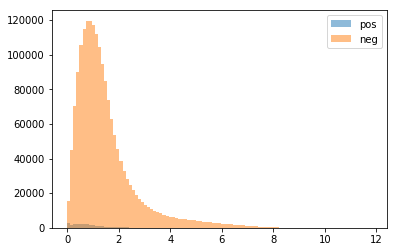

In [25]:
pair_dist = np.array(pair_dist)
pair_label = np.array(pair_label)

bins = np.linspace(pair_dist.min(), pair_dist.max(), 100)

plt.hist(pair_dist[pair_label], bins, alpha=0.5, label='pos')
plt.hist(pair_dist[pair_label == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [23]:
# pair_dist = []
# pair_label = []

# for i in np.arange(x_train.shape[0]):
#     for j in range(i, x_train.shape[0]):
#         d = np.sqrt(np.power(x_train[i] - x_train[j], 2).sum())
#         pair_dist.append(d)
        
#         if y_train[i] == y_train[j]:
#             pair_label.append(True)
#         else:
#             pair_label.append(False)
    
# print roc_auc_score(y_true=pair_label, y_score=pair_dist)

In [30]:
mean = np.mean(x_test_encoded[0], axis=0)
print mean

std = np.std(x_test_encoded[0], axis=0)
print std

[-0.613457   0.3743873]
[0.9110179 0.9853236]


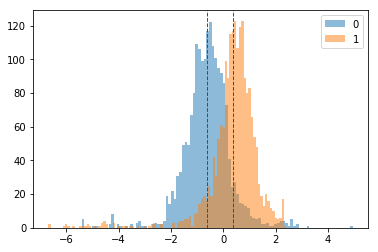

In [33]:
plt.hist(x_test_encoded[0, :, 0], bins=100, alpha=0.5, label='0')
plt.hist(x_test_encoded[0, :, 1], bins=100, alpha=0.5, label='1')

plt.axvline(mean[0], color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean[1], color='red', linestyle='dashed', linewidth=1)

plt.legend()
plt.show()

### Apply Generative Probabilistic Model

In [89]:
N_SINGLETONS = 75
N_PAIRS = 5

In [90]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [91]:
singletons = np.random.choice(range(y_train.max() + 1), N_SINGLETONS, replace=False)
# pairs = np.random.choice( )
print singletons

[18  1 83 75 21 38 66  4 44 37 61 76 58 27 69 26 79 73  3  7 33 15 35 56
 23 47 50 60 11 85  8 78 71 13 63 42 57 32 77 48 67 24 41 45 64 86 34  2
 12 31 68 82 54 53 51 59 65 17 20 46 16 62 40 14 87 70  9 80  6 19 29 84
 39  0 25]


In [92]:
remaining_idx = []
for i in np.arange(y_train.max() + 1):
    if i not in singletons:
        remaining_idx.append(i)
print remaining_idx

[5, 10, 22, 28, 30, 36, 43, 49, 52, 55, 72, 74, 81]


In [93]:
pairs = np.random.choice(remaining_idx, N_PAIRS, replace=False)
print pairs

[81 55 10 52 28]


In [100]:
vec_list = []
labels = []
GT_POS_PAIRS = []

pid_list = data_dict.keys()

for p in range(len(pairs)):
    pid = pid_list[pairs[p]]
    w1, w2 = np.random.choice(data_dict[pid].keys(), 2)
    app_vec1, app_vec2 = data_dict[pid][w1], data_dict[pid][w2]
    
    vec_list.append(app_vec1 / (app_vec1.max() + 1e-5))
    vec_list.append(app_vec1 / (app_vec2.max() + 1e-5))
    
    labels.append(p + 1)
    labels.append(p + 1)
    GT_POS_PAIRS.append((2* p, 2* p + 1))

for s in singletons:
    pid = pid_list[s]
    w = np.random.choice(data_dict[pid].keys(), 1)
    app_vec = data_dict[pid][w[0]]
    vec_list.append(app_vec / (app_vec.max() + 1e-5))
    labels.append(0)

In [101]:
points = encoder.predict(np.array(vec_list))[2]

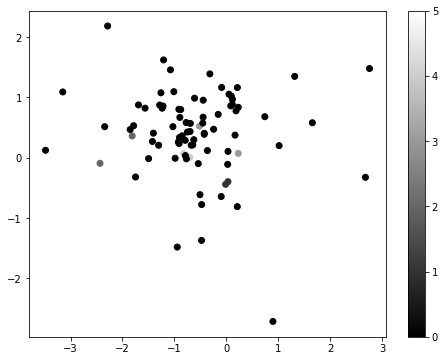

In [102]:
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], c=labels)
plt.colorbar()
plt.show()

In [114]:
N_DIM = len(points.shape)
test_mean = np.mean(points, axis=0)
print test_mean
sigma = np.std(points)
print test_std

[-0.6143942   0.41295755]
1.0073687


In [115]:
nu = 0.2

In [116]:
start = time()

LR_arr = []
LR_idx = []

for i in np.arange(points.shape[0]):
    for j in np.arange(i, points.shape[0]):
        midpoint = 0.5 * (points[i] + points[j])
        m = euclidean(midpoint, test_mean)
        d = euclidean(0.5* (points[i] - points[j]), [0,0])
        
        m_prime = m / sigma
        d_prime = d / sigma
        t = nu / sigma
        
        LR = np.power(0.5/t, N_DIM)* np.exp(0.5*(np.power(m_prime,2)+ np.power(d_prime,2)*(2- np.power(t,-2))))
        LR_arr.append(LR)
        
        if (i, j) in GT_POS_PAIRS:
            LR_idx.append(True)
        else:
            LR_idx.append(False)
            
print 'time elapsed: %f s' % (time() - start)

LR_arr = np.array(LR_arr)
LR_idx = np.array(LR_idx)

time elapsed: 0.409779 s


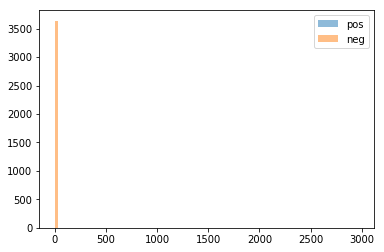

In [117]:
bins = np.linspace(LR_arr.min(), LR_arr.max(), 100)

plt.hist(LR_arr[LR_idx], bins, alpha=0.5, label='pos')
plt.hist(LR_arr[LR_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [118]:
print roc_auc_score(y_true=LR_idx, y_score=LR_arr)

0.8782465753424658
